In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils import decorate, configure_plot_style, AIBM_COLORS

configure_plot_style()

In [3]:
filename = "indicator-data-export_LR.GALP.AG15T24.F_LR.GALP.AG15T24.M_LR.GALP.AG15T99.F_and_3_more/data.csv"

df = pd.read_csv(filename)
df.head()


,indicatorId,geoUnit,year,value,qualifier,magnitude
0,LR.GALP.AG15T24.F,ABW,2020,99,UIS_EST,NaN
1,LR.GALP.AG15T24.F,AGO,2022,81,UIS_EST,NaN
2,LR.GALP.AG15T24.F,ALB,2022,100,UIS_EST,NaN
3,LR.GALP.AG15T24.F,BDI,2022,93,UIS_EST,NaN
4,LR.GALP.AG15T24.F,BEN,2006,31,UIS_EST,NaN


In [4]:
from utils import iso_country_dict

country_map = pd.Series(iso_country_dict)
df['country'] = df['geoUnit'].map(country_map)
df.head()

,indicatorId,geoUnit,year,value,qualifier,magnitude,country
0,LR.GALP.AG15T24.F,ABW,2020,99,UIS_EST,NaN,Aruba
1,LR.GALP.AG15T24.F,AGO,2022,81,UIS_EST,NaN,Angola
2,LR.GALP.AG15T24.F,ALB,2022,100,UIS_EST,NaN,Albania
3,LR.GALP.AG15T24.F,BDI,2022,93,UIS_EST,NaN,Burundi
4,LR.GALP.AG15T24.F,BEN,2006,31,UIS_EST,NaN,Benin


In [5]:

# from each group, select the row with the latest date
grouped = df.groupby(["indicatorId", "geoUnit"]).last()
grouped.head()


year  value qualifier  magnitude  country
indicatorId       geoUnit                                           
LR.GALP.AG15T24.F ABW      2020     99   UIS_EST        NaN    Aruba
                  AGO      2022     81   UIS_EST        NaN   Angola
                  ALB      2022    100   UIS_EST        NaN  Albania
                  BDI      2022     93   UIS_EST        NaN  Burundi
                  BEN      2012     41   UIS_EST        NaN    Benin

In [18]:
group = 'LR.GALP.AG25T64'
group = 'LR.GALP.AG15T24'


male = grouped.loc[f'{group}.M']
male.index = male['country']
female = grouped.loc[f'{group}.F']
female.index = female['country']

male.head()

,year,value,qualifier,magnitude,country
country,,,,,
Aruba,2020,100,UIS_EST,NaN,Aruba
Angola,2022,86,UIS_EST,NaN,Angola
Albania,2022,99,UIS_EST,NaN,Albania
Burundi,2022,94,UIS_EST,NaN,Burundi
Benin,2012,64,UIS_EST,NaN,Benin


In [19]:
literacy = pd.concat([male, female], axis=1, keys=["male", "female"])
literacy.head()

male                                    female                  \
         year value qualifier magnitude  country   year value qualifier   
country                                                                   
Aruba    2020   100   UIS_EST       NaN    Aruba   2020    99   UIS_EST   
Angola   2022    86   UIS_EST       NaN   Angola   2022    81   UIS_EST   
Albania  2022    99   UIS_EST       NaN  Albania   2022   100   UIS_EST   
Burundi  2022    94   UIS_EST       NaN  Burundi   2022    93   UIS_EST   
Benin    2012    64   UIS_EST       NaN    Benin   2012    41   UIS_EST   

                            
        magnitude  country  
country                     
Aruba         NaN    Aruba  
Angola        NaN   Angola  
Albania       NaN  Albania  
Burundi       NaN  Burundi  
Benin         NaN    Benin

In [20]:
literacy['ratio'] = literacy['female', 'value'] / literacy['male', 'value']
literacy.head()

male                                    female                  \
         year value qualifier magnitude  country   year value qualifier   
country                                                                   
Aruba    2020   100   UIS_EST       NaN    Aruba   2020    99   UIS_EST   
Angola   2022    86   UIS_EST       NaN   Angola   2022    81   UIS_EST   
Albania  2022    99   UIS_EST       NaN  Albania   2022   100   UIS_EST   
Burundi  2022    94   UIS_EST       NaN  Burundi   2022    93   UIS_EST   
Benin    2012    64   UIS_EST       NaN    Benin   2012    41   UIS_EST   

                               ratio  
        magnitude  country            
country                               
Aruba         NaN    Aruba  0.990000  
Angola        NaN   Angola  0.941860  
Albania       NaN  Albania  1.010101  
Burundi       NaN  Burundi  0.989362  
Benin         NaN    Benin  0.640625

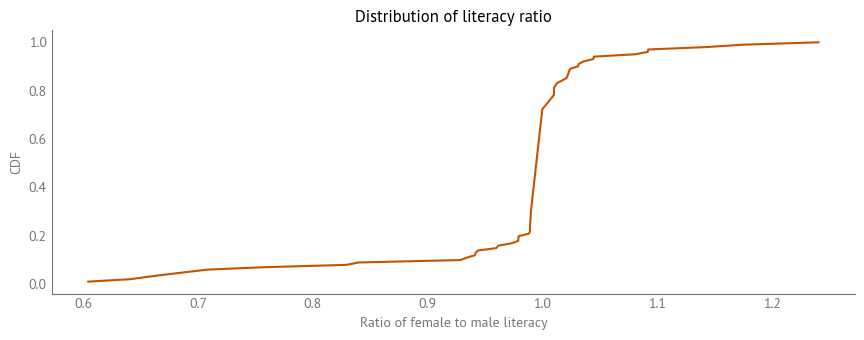

In [21]:
from empiricaldist import Cdf

cdf = Cdf.from_seq(literacy['ratio'])
cdf.plot()
decorate(xlabel='Ratio of female to male literacy',
         ylabel='CDF',
         title='Distribution of literacy ratio')

In [23]:
literacy.sort_values('ratio', ascending=False).head(30)

male                                               female  \
                    year value qualifier magnitude             country   year   
country                                                                         
Bangladesh          2007    54   UIS_EST       NaN          Bangladesh   2007   
Lesotho             2014    80   UIS_EST       NaN             Lesotho   2014   
Gambia              2022    70   UIS_EST       NaN              Gambia   2022   
Papua New Guinea    2010    65   UIS_EST       NaN    Papua New Guinea   2010   
Zimbabwe            2022    87   UIS_EST       NaN            Zimbabwe   2022   
Malawi              2022    74   UIS_EST       NaN              Malawi   2022   
Gabon               2022    89   UIS_EST       NaN               Gabon   2022   
Nicaragua           2015    90   UIS_EST       NaN           Nicaragua   2015   
Timor-Leste         2020    84   UIS_EST       NaN         Timor-Leste   2020   
Namibia             2021    94   UIS_EST       NaN             Namibia   2021   
Botswana            2013    96   UIS_EST       NaN            Botswana   2013   
Comoros             2022    81   UIS_EST       NaN             Comoros   2022   
Belize              2001    86   UIS_EST       NaN              Belize   2001   
Kenya               2022    88   UIS_EST       NaN               Kenya   2022   
Uganda              2022    91   UIS_EST       NaN              Uganda   2022   
Cambodia            2022    95   UIS_EST       NaN            Cambodia   2022   
Eswatini            2020    95   UIS_EST       NaN            Eswatini   2020   
Rwanda              2010    77   UIS_EST       NaN              Rwanda   2010   
Tanzania            2022    88   UIS_EST       NaN            Tanzania   2022   
Thailand            2021    98   UIS_EST       NaN            Thailand   2021   
Cape Verde          2022    98   UIS_EST       NaN          Cape Verde   2022   
Venezuela           2022    98   UIS_EST       NaN           Venezuela   2022   
Mauritius           2021    99   UIS_EST       NaN           Mauritius   2021   
Costa Rica          2021    99   UIS_EST       NaN          Costa Rica   2021   
Brazil              2022    99   UIS_EST       NaN              Brazil   2022   
Albania             2022    99   UIS_EST       NaN             Albania   2022   
Malta               2021    99   UIS_EST       NaN               Malta   2021   
Seychelles          2020    99   UIS_EST       NaN          Seychelles   2020   
Dominican Republic  2022    99   UIS_EST       NaN  Dominican Republic   2022   
Estonia             2021   100   UIS_EST       NaN             Estonia   2021   

                                                                     ratio  
                   value qualifier magnitude             country            
country                                                                     
Bangladesh            67   UIS_EST       NaN          Bangladesh  1.240741  
Lesotho               94   UIS_EST       NaN             Lesotho  1.175000  
Gambia                80   UIS_EST       NaN              Gambia  1.142857  
Papua New Guinea      71   UIS_EST       NaN    Papua New Guinea  1.092308  
Zimbabwe              95   UIS_EST       NaN            Zimbabwe  1.091954  
Malawi                80   UIS_EST       NaN              Malawi  1.081081  
Gabon                 93   UIS_EST       NaN               Gabon  1.044944  
Nicaragua             94   UIS_EST       NaN           Nicaragua  1.044444  
Timor-Leste           87   UIS_EST       NaN         Timor-Leste  1.035714  
Namibia               97   UIS_EST       NaN             Namibia  1.031915  
Botswana              99   UIS_EST       NaN            Botswana  1.031250  
Comoros               83   UIS_EST       NaN             Comoros  1.024691  
Belize                88   UIS_EST       NaN              Belize  1.023256  
Kenya                 90   UIS_EST       NaN               Kenya  1.022727  
Uganda                93   UIS_EST   

In [12]:
df = pd.read_csv("wef_literacy_rate.csv")
df.shape

(146, 7)

In [13]:
for country in df['country'].unique():
    if len(country) > 15:
        print(country)

Bosnia and Herzegovina
Brunei Darussalam
Congo, Democratic Republic of t
Dominican Republic
Moldova, Republic of
United Arab Emirates
United Republic of Tanzania
United States of America


In [14]:
df['country'] = df['country'].replace({
    'United States of America': 'United States',
    'Brunei Darussalam': 'Brunei',
    'Moldova, Republic of': 'Moldova',
    'Congo, Democratic Republic of t': 'D.R. Congo',
    'United Republic of Tanzania': 'Tanzania',
    'Viet Nam': 'Vietnam',
    'Bosnia and Herzegovina': 'Bosnia-Herzegovina',
    'Lao PDR': 'Laos',
})

In [15]:
df['country'].unique()

array(['Albania', 'Algeria', 'Angola', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia-Herzegovina', 'Botswana', 'Brazil', 'Brunei',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Cape Verde', 'Chad', 'Chile', 'China', 'Colombia',
       'Comoros', 'D.R. Congo', 'Costa Rica', "Côte D'Ivoire", 'Croatia',
       'Cyprus', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji',
       'Finland', 'France', 'Gambia', 'Georgia', 'Germany', 'Ghana',
       'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Honduras', 'Hungary',
       'Iceland', 'India', 'Indonesia', 'Iran', 'Ireland', 'Israel',
       'Italy', 'Jamaica', 'Japan', 'Jordan', 'Kazakhstan', 'Kenya',
       'Kuwait', 'Kyrgyzstan', 'Lao PDR', 'Latvia', 'Lebanon', 'Lesotho',
       'Libe

In [8]:
df.head()

,country,page_number,score,rank,diff,left,right
0,Albania,83,NaN,NaN,NaN,NaN,NaN
1,Algeria,85,NaN,NaN,NaN,NaN,NaN
2,Angola,87,NaN,NaN,NaN,NaN,NaN
3,Argentina,89,NaN,NaN,NaN,NaN,NaN
4,Armenia,91,NaN,NaN,NaN,NaN,NaN


In [9]:
df.tail()

,country,page_number,score,rank,diff,left,right
141,Uzbekistan,365,NaN,NaN,NaN,NaN,NaN
142,Vanuatu,367,NaN,NaN,NaN,NaN,NaN
143,Vietnam,369,NaN,NaN,NaN,NaN,NaN
144,Zambia,371,NaN,NaN,NaN,NaN,NaN
145,Zimbabwe,373,NaN,NaN,NaN,NaN,NaN


The study includes 146 countries. We have secondary education data for 135 of them (missing 11).

In 104/135 countries, women participate in secondary education at rates equal or higher than men, so there is a 104-way tie for Rank #1.

So in 104 countries, the problem of gender equality in higher education is entirely solved, and there is no reason to allocate any further attention or resources to the problem. Yay!

In [10]:
df['rank'].value_counts(dropna=False)

rank
NaN    146
Name: count, dtype: int64

Only 31 countries received less than a perfect score in this category.

In [11]:
dinged = df['score'] < 1
dinged.sum()

np.int64(0)

Here is the distribution of their scores.

In [12]:
from empiricaldist import Cdf

cdf_score = Cdf.from_seq(df.loc[dinged, 'score'])
cdf_score.plot()
decorate(xlabel='Literacy Score', ylabel='CDF')

IndexError: index -1 is out of bounds for axis 0 with size 0

Here is the distribution of differences (female minus male in percentage points) for all countries with valid data.

In [ ]:
cdf_difference_fm = Cdf.from_seq(df['diff'])
cdf_difference_fm.plot()
decorate(xlabel='Literacy Difference F-M', ylabel='CDF')


In countries where women are lagging, they lag by fewer than 10 percentage points in most cases. In countries where men are lagging, the differences are much bigger, sometimes 40-60 percentage points.
So the WEF metrics are hiding the biggest differences.

Here are the countries where women lag men.

In [ ]:
subset = df[dinged]
subset.sort_values("diff", ascending=False)

The data for South Korea are weird. Male enrollment is 111% and for women it's "only" 95%.
Maybe the denominator is college-age people and "college age" is shifted because of mandatory military service?

The scores are based on ratios, not differences, so let's compute those.

In [ ]:
df['ratio'] = df['left'] / df['right']
df['ratio'].describe()

Looks like the ratio IS the score.

In [ ]:
subset = df[dinged]
plt.plot([0, 1], [0, 1], color='gray', alpha=0.4)
plt.scatter(subset['ratio'], subset['score'])
decorate(xlabel='Ratio', ylabel='Score')


In [ ]:
from scipy.stats import linregress

slope, intercept, r_value, p_value, std_err = linregress(
    subset['ratio'], subset['score'])

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-value: {r_value}")
print(f"P-value: {p_value}")
print(f"Standard Error: {std_err}")

So here are the revised, symmetric scores.

In [ ]:
df['revised_score'] = df['ratio']
df['revised_score'].describe()

Here's the distribution of revised scores.

In [ ]:
cdf_score = Cdf.from_seq(df['revised_score'])
cdf_score.plot()
decorate(xlabel='Revised Enrolment Score', ylabel='CDF')

In [ ]:
revised = df[~dinged].dropna(subset=['ratio']).sort_values('revised_score')
revised.shape

In [ ]:
# make a figure that shows a horizontal line for each country that
# connects the revised score and the secondary enrolment score
# with a circle for the original and a triangle for the revised

from utils import add_title, add_subtext, add_logo

fig, ax = plt.subplots(figsize=(6, 15))
plt.hlines(revised['country'], 
           revised['score'], revised['revised_score'], 
           color=AIBM_COLORS['light_gray'])
plt.plot(revised['score'], revised['country'], '|', 
         color=AIBM_COLORS['blue'])
plt.plot(revised['revised_score'], revised['country'], '<', 
         color=AIBM_COLORS['blue'])
ax.invert_yaxis()

decorate(xlabel='Literacy Rate', ylim=[len(revised)+1, -1])
add_title("Revised Scores Are Very Different For Many Countries",
          "Literacy rate", y=1.01)
add_subtext("Source: World Economic Forum", y=-0.05)
logo = add_logo(location=(1.0, -0.05))



And here's the new ranking of countries based on revised scores.

In [ ]:
columns = ['revised_rank', 'country', 'score', 'revised_score', 'diff']
df_sorted = df.dropna(subset=['ratio']).sort_values(by='revised_score', ascending=False)
df_sorted['revised_rank'] = np.arange(1, len(df_sorted)+1)
table = df_sorted[columns].round(2)
table.to_csv("wef_literacy_rate_table.csv", index=False)

In [ ]:


df_sorted[columns].head(40).round(2)

In [ ]:
df_sorted[columns].tail(50).round(2)

In [ ]:
df.query("country == 'Qatar'")

In [ ]:
import seaborn as sns

options = dict(cut=0, bw_adjust=0.7)

sns.kdeplot(df['score'], label='WEF truncated scores', **options)
sns.kdeplot(df['revised_score'], label='Revised symmetric scores', **options)

decorate(xlabel='Gender equality score')

add_title("The Distribution of Scores Is Very Different",
          "Literacy rate")
add_subtext("Source: World Economic Forum", y=-0.25)
logo = add_logo(location=(1.0, -0.25))
None